In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaSarimax import PcaSarimax
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Energy Appliances

In [5]:
filename = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv'
data = pd.read_csv(filename)
data.pop('date')
data.pop('rv1')
data.pop('rv2')
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


### Dataset Energy Appliances: columns

In [6]:
# cols = data.columns
# list_cols = list(cols)
# list_cols.append('Appliances_t+1')
# print(list_cols)

## Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [7]:
data = series_to_supervised_miso(data, 1, 1,endog_var='Appliances')
data.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50


## Model: PcaSarimax - PCA-SARIMAX

### Define SARIMAX parameters 

In [8]:
pca_sarimax = PcaSarimax(n_components = 3,
                       endogen_variable = 'Appliances(t-1)',
                       order = [0, 0, 0],
                       seasonal_order = [0,0,0,0])

In [9]:
df_train = data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
train = sample_first_prows(data, perc=0.30)

In [10]:
reduced = pca_sarimax.apply_pca(train)
reduced.head(2)

,C0,C1,C2,Appliances(t-1)
0,-0.372708,0.329091,0.035962,60.0
1,-0.365147,0.323553,0.031652,60.0


In [11]:
exog = reduced.drop(labels=['Appliances(t-1)'], axis=1)
exog.head(2)

,C0,C1,C2
0,-0.372708,0.329091,0.035962
1,-0.365147,0.323553,0.031652


In [12]:
endog = reduced['Appliances(t-1)']
endog.head(3)

0    60.0
1    60.0
2    50.0
Name: Appliances(t-1), dtype: float64

In [13]:
train_y = endog
train_X = exog

In [ ]:
# Define arimax paraters using the embedded data 
from pmdarima.arima import auto_arima
sarimax_model = auto_arima(train_y,
                       exogenous= train_X,
                       test='adf',
                       start_p=0,
                       start_q=0,
                       max_p=5,
                       max_q=5,
                       start_Q=0,
                       start_P=0,
                       max_P=5,
                       max_Q=5,
                       m=7,
                       seasonal=True,
                       d=None,
                       D=1,
                       max_D=5,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
# #                        n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=75005.277, Time=0.38 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=69365.852, Time=10.86 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=36.41 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=75003.343, Time=6.26 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=71412.790, Time=1.30 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=68791.852, Time=32.35 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=68460.810, Time=49.33 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=68285.441, Time=83.93 sec
 ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=68136.967, Time=135.29 sec
 ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=205.73 sec
 ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=160.41 sec
 ARIMA(0,0,0)(5,1,0)[7] intercept   : AIC=72776.388, Time=178.68 sec
 ARIMA(2,0,0)(5,1,0)[7] intercept   : AIC=68052.850, Time=105.12 sec
 ARIMA(2,0,0)(4,1,0)[7] intercept   : AIC=68194.141, Time=83.07 sec
 ARIMA(2,0,0)(5,1,1)[

In [15]:
# Performing stepwise search to minimize aic
# ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=75005.277, Time=0.38 sec
#  ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=69365.852, Time=10.86 sec
#  ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=36.41 sec
#  ARIMA(0,0,0)(0,1,0)[7]             : AIC=75003.343, Time=6.26 sec
#  ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=71412.790, Time=1.30 sec
#  ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=68791.852, Time=32.35 sec
#  ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=68460.810, Time=49.33 sec
#  ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=68285.441, Time=83.93 sec
#  ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=68136.967, Time=135.29 sec
#  ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=205.73 sec
#  ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=160.41 sec
#  ARIMA(0,0,0)(5,1,0)[7] intercept   : AIC=72776.388, Time=178.68 sec
#  ARIMA(2,0,0)(5,1,0)[7] intercept   : AIC=68052.850, Time=105.12 sec
#  ARIMA(2,0,0)(4,1,0)[7] intercept   : AIC=68194.141, Time=83.07 sec
#  ARIMA(2,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=254.29 sec
#  ARIMA(2,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=174.13 sec
#  ARIMA(3,0,0)(5,1,0)[7] intercept   : AIC=67989.323, Time=127.15 sec
#  ARIMA(3,0,0)(4,1,0)[7] intercept   : AIC=68136.326, Time=95.38 sec
#  ARIMA(3,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=294.38 sec
#  ARIMA(3,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=140.51 sec
#  ARIMA(4,0,0)(5,1,0)[7] intercept   : AIC=67982.934, Time=185.41 sec
#  ARIMA(4,0,0)(4,1,0)[7] intercept   : AIC=68134.437, Time=119.20 sec

### Test the model with the best parameters 

In [16]:
pca_arimax = PcaSarimax(n_components = 3,
                       endogen_variable = 'Appliances(t-1)',
                       order=[4,0,0],
                       seasonal_order=[5,1,0,7])

In [26]:
df_train = data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
df_test = data.loc[:,'lights(t-1)':'Appliances(t)']
train = sample_first_prows(df_train,0.75)
test = df_test.iloc[max(train.index):]

In [18]:
model, sarimax, pca_reduced_train = pca_arimax.run_train_model(train)

(14800, 25)
(14800,)


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                14800
Model:             SARIMAX(3, 0, 1)x(5, 1, [], 7)   Log Likelihood              -84573.705
Date:                            Tue, 21 Sep 2021   AIC                         169217.410
Time:                                    23:44:10   BIC                         169483.387
Sample:                                         0   HQIC                        169305.728
                                          - 14800                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0969      0.086    -12.778      0.000      -1.265      -0.929
x2           -40.1247      9.216     -4.354      0.000     -58.187     -22.062
x3             7.9104      0.701     11.278      0.000       6.536       9.285
x4           -18.0210      5.620     -3.207      0.001     -29.035      -7.007
x5           -24.6909      1.471    -16.789      0.000     -27.573     -21.808
x6           -92.7336      5.951    -15.584      0.000    -104.397     -81.071
x7            21.3085      2.075     10.269      0.000      17.241      25.376
x8            -9.5306      3.875     -2.459      0.014     -17.126      -1.936
x9             0.5862      2.129      0.275      0.783      -3.587       4.759
x10           21.9202      5.109      4.290      0.000      11.906      31.934
x11           -0.6215      0.280     -2.218      0.027      -1.171      -0.072
x12            2.6942      2.444      1.102      0.270      -2.096       7.484
x13            0.8375      0.353      2.376      0.018       0.147       1.528
x14           15.0180      8.309      1.807      0.071      -1.267      31.303
x15           -4.2509      2.178     -1.952      0.051      -8.519       0.018
x16           31.8440      6.700      4.753      0.000      18.713      44.975
x17           -2.2298      1.971     -1.131      0.258      -6.094       1.634
x18            4.0625     12.661      0.321      0.748     -20.752      28.877
x19           -7.4609      1.859     -4.012      0.000     -11.105      -3.816
x20          -10.7161      9.830     -1.090      0.276     -29.982       8.550
x21           -2.6568      2.061     -1.289      0.197      -6.696       1.383
x22           -2.5201      1.869     -1.349      0.177      -6.182       1.142
x23            0.1239      1.885      0.066      0.948      -3.570       3.818
x24            0.3763      0.176      2.144      0.032       0.032       0.720
x25           14.1621      9.312      1.521      0.128      -4.088      32.413
ar.L1          1.4773      0.017     88.450      0.000       1.445       1.510
ar.L2         -0.6711      0.014    -48.364      0.000      -0.698      -0.644
ar.L3          0.1574      0.006     25.536      0.000       0.145       0.169
ma.L1         -0.7189      0.016    -43.771      0.000      -0.751      -0.687
ar.S.L7       -0.8705      0.006   -134.902      0.000      -0.883      -0.858
ar.S.L14      -0.6881      0.009    -79.954      0.000      -0.705      -0.671
ar.S.L21      -0.5222      0.009    -56.038      0.000      -0.540      -0.504
ar.S.L28      -0.3242      0.009    -34.546      0.000      -0.343      -0.306
ar.S.L35      -0.1690      0.007    -24.190      0.000      -0.183      -0.155
sigma2      6007.2749     30.995    193.812      0.000    5946.525    6068.025
===================================================================================
Ljung-Box (L1) (Q):                   9.13   Ja

In [20]:
pca_reduced_train.head(2)

,C0,C1,C2,Appliances(t-1)
0,-0.790653,0.386887,0.168916,60.0
1,-0.788940,0.379753,0.161812,60.0


In [28]:
#ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
test.rename(columns = {'Appliances(t)': 'Appliances(t-1)'}, inplace = True)
start = len(train)
end = len(train) + len(test) -1
forecast, pca_reduced_test = pca_arimax.run_test_model(test, sarimax,start,end)

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [29]:
forecast

array([ 250.70514062,  204.84522495,  208.47978944, ...,  -75.48662929,
       -140.63264148, -163.32214765])

In [32]:
#pca_reduced_test['Appliances(t-1)'].head(2)
pca_reduced_test.head(5)

,C0,C1,C2,Appliances(t-1)
0,-0.536229,0.379623,-0.028061,280
1,-0.526844,0.400591,-0.024446,320
2,-0.519235,0.384981,-0.004433,360
3,-0.516002,0.379201,0.000447,210
4,-0.502806,0.404541,-0.003880,90


In [33]:
print(Measures.rmse(pca_reduced_test['Appliances(t-1)'],forecast))
print(Measures.mape(pca_reduced_test['Appliances(t-1)'],forecast))

225.80870073189277
264.6636625549886


## Model: PcaSarimax - PCA-SARIMAX - Final model 

In [ ]:
#order=(0,0,1), seasonal_order=(0,1,1,7) ==> 198.542782	161.229953	233.440971	55.778863
# order=[4,0,0],seasonal_order=[5,1,0,7]==> 231.298042	192.277452	278.761252	60.937779
# order=[1,0,0],seasonal_order=[1,1,1,7]==> 193.390913	154.115144	215.690672	53.695569
# order=[2,0,0],seasonal_order=[1,1,1,7]==> 197.281172	158.910376	223.941404	56.833807
# order=[1,0,1],seasonal_order=[1,1,1,7]==> 194.718208	155.646919	217.600043	56.32993
# order=[1,0,1],seasonal_order=[1,0,1,7]==> 159.672044	125.575645	172.611668	52.118226
# order=[1,0,0],seasonal_order=[1,0,1,7]==> 159.428875	124.994671	171.189957	51.985863
#159.428875	124.994671	171.189957	51.985863
# order=[1,0,0],seasonal_order=[1,0,0,7]==> 158.768037	124.465851	170.801876	51.938651
#158.768037	124.465851	170.801876	51.938651
#order=[1,0,0],seasonal_order=[0,0,0,7]==> 158.135784	124.097266	170.87774	51.708168
# order=[1,0,0],seasonal_order=[0,0,0,0]==>158.135784	124.097266	170.87774	51.708168

# order=[2,0,0],seasonal_order=[0,0,0,0]==> 158.946251	125.183403	172.284921	52.377286
#order=[2,0,1],seasonal_order=[0,0,0,0]==> 158.744321	124.722451	171.211912	52.230366

#Utilizar o ARIMAX melhor um pouquinho, quase nada 

In [35]:
pca_sarimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'Appliances(t-1)',
                       order=[1,0,0],
                       seasonal_order=[1,0,0,7])

## Sliding Window PyFTS: PCA-SARIMAX

--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:24:37] getting statistics


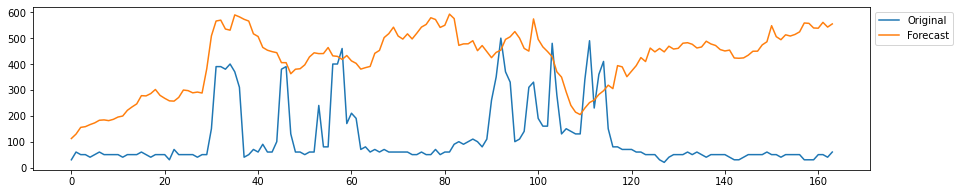

--------------------
training window 657


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:24:44] getting statistics


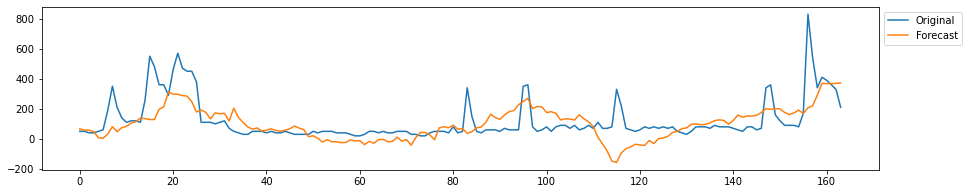

--------------------
training window 1314


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:24:50] getting statistics


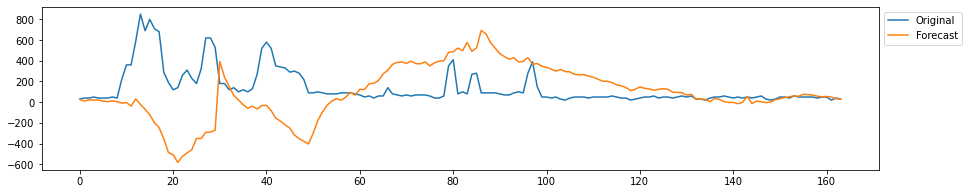

--------------------
training window 1971


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:24:56] getting statistics


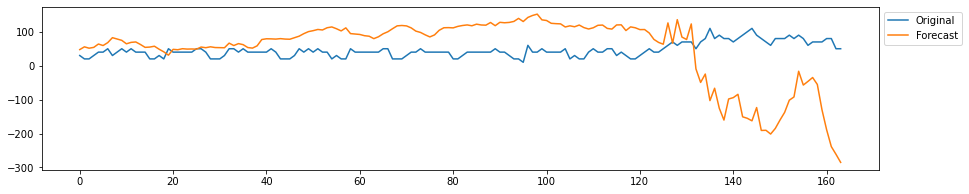

--------------------
training window 2628


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:02] getting statistics


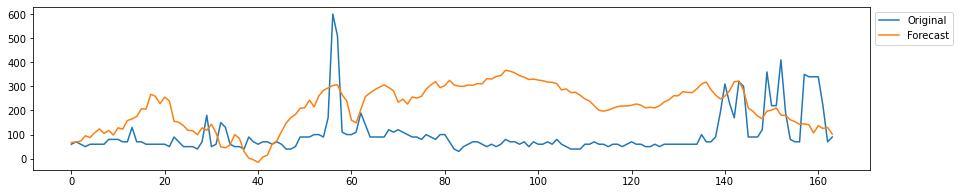

--------------------
training window 3285


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:07] getting statistics


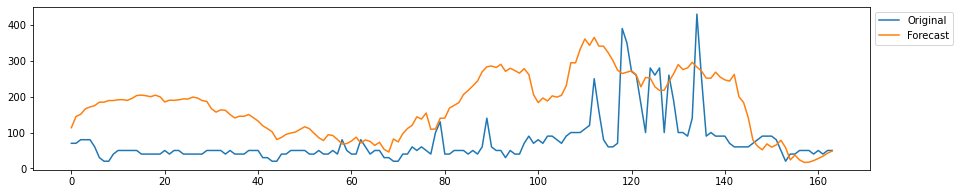

--------------------
training window 3942


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:13] getting statistics


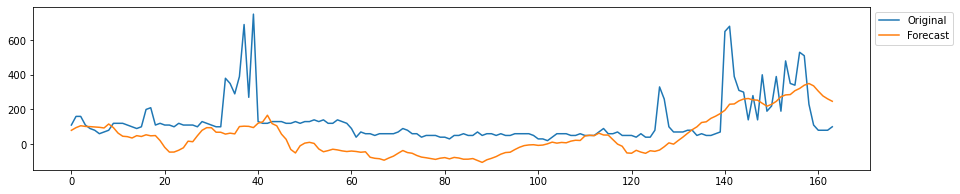

--------------------
training window 4599


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:19] getting statistics


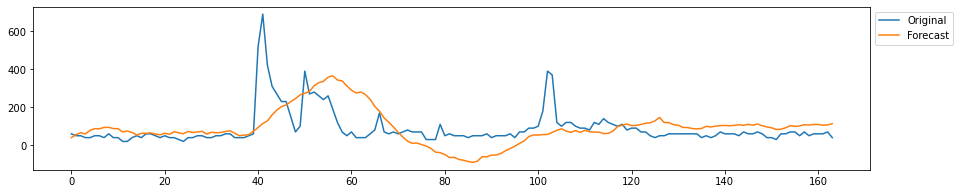

--------------------
training window 5256


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:27] getting statistics


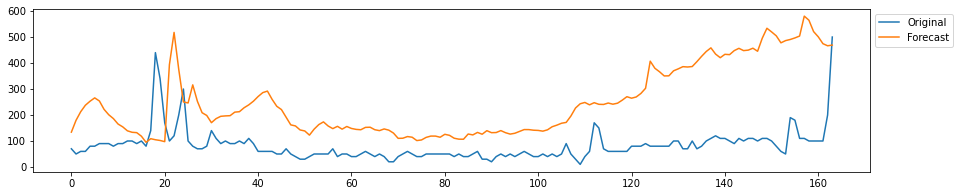

--------------------
training window 5913


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:33] getting statistics


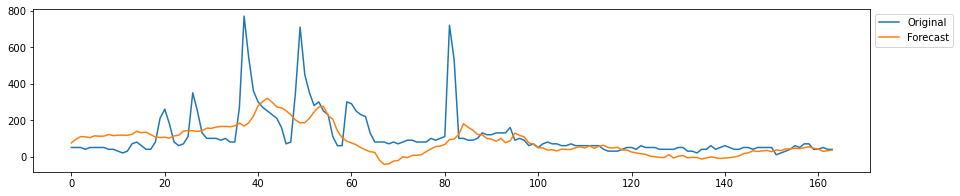

--------------------
training window 6570


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:38] getting statistics


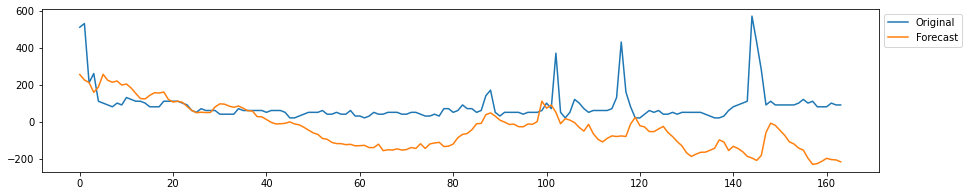

--------------------
training window 7227


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:43] getting statistics


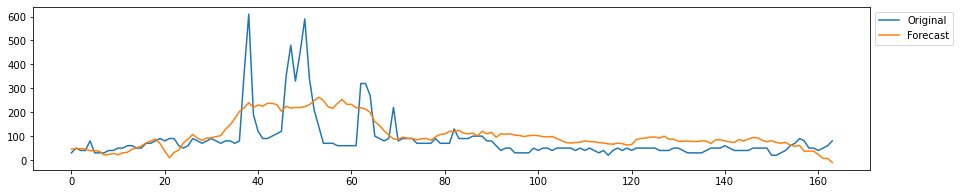

--------------------
training window 7884


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:49] getting statistics


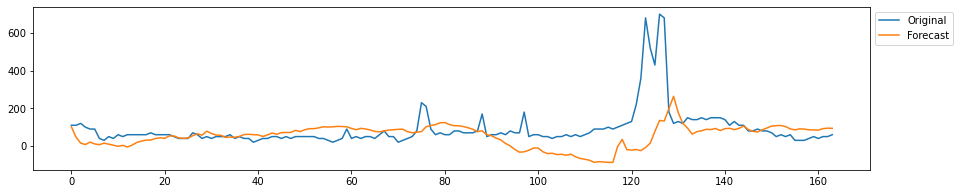

--------------------
training window 8541


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:25:54] getting statistics


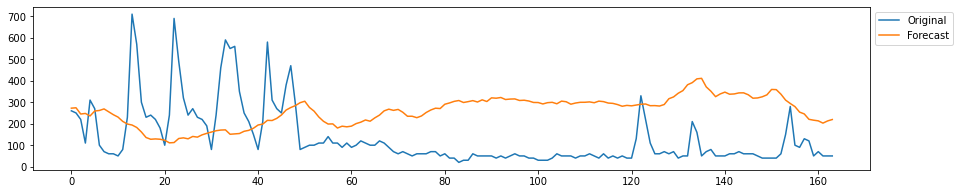

--------------------
training window 9198


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:00] getting statistics


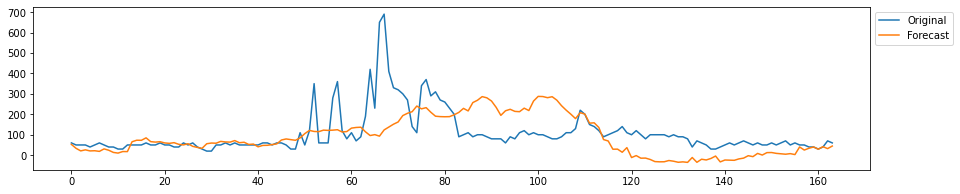

--------------------
training window 9855


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:05] getting statistics


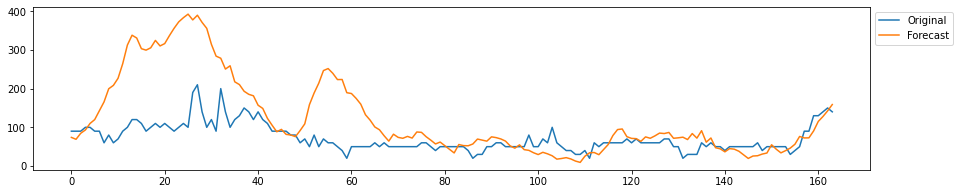

--------------------
training window 10512


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:10] getting statistics


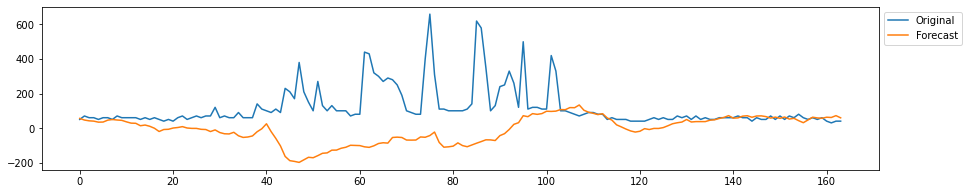

--------------------
training window 11169


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:16] getting statistics


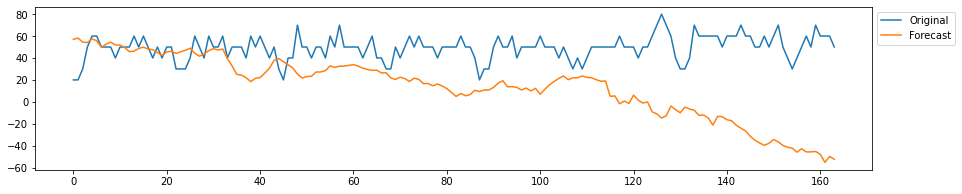

--------------------
training window 11826


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:21] getting statistics


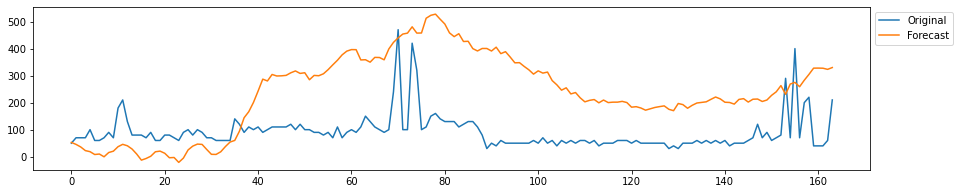

--------------------
training window 12483


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:28] getting statistics


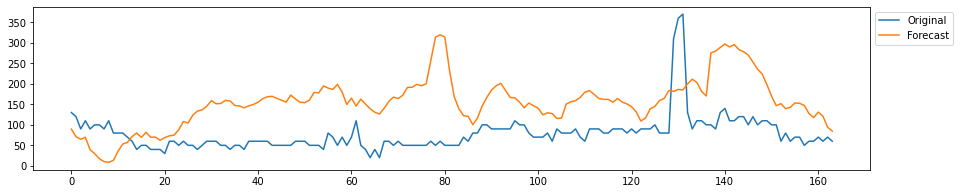

--------------------
training window 13140


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:35] getting statistics


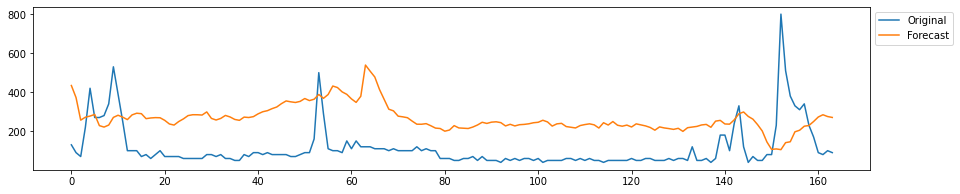

--------------------
training window 13797


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:41] getting statistics


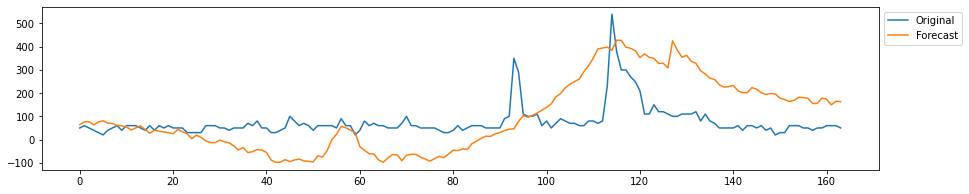

--------------------
training window 14454


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:48] getting statistics


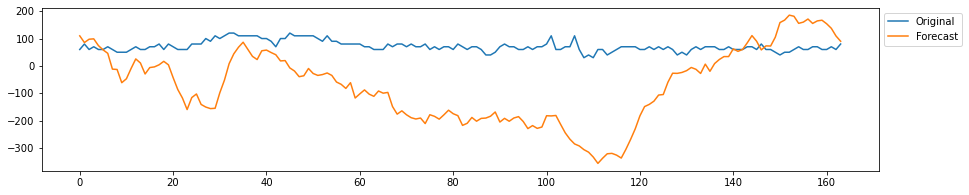

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:26:56] getting statistics


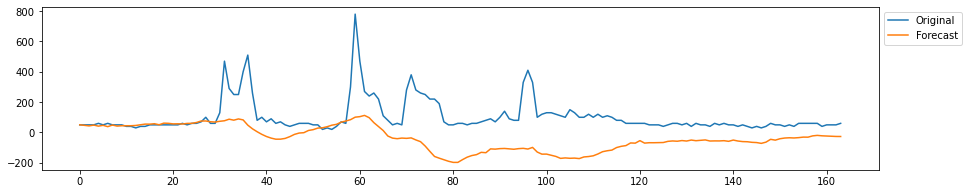

--------------------
training window 15768


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:03] getting statistics


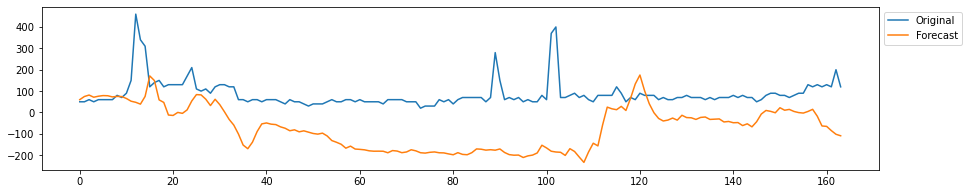

--------------------
training window 16425


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:10] getting statistics


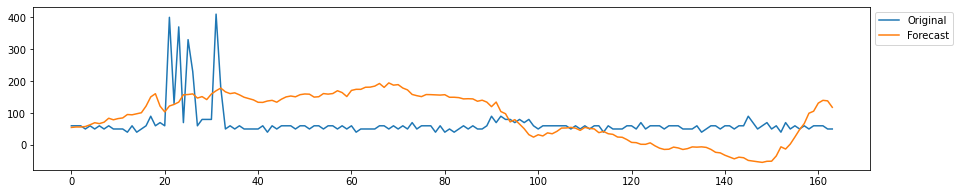

--------------------
training window 17082


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:17] getting statistics


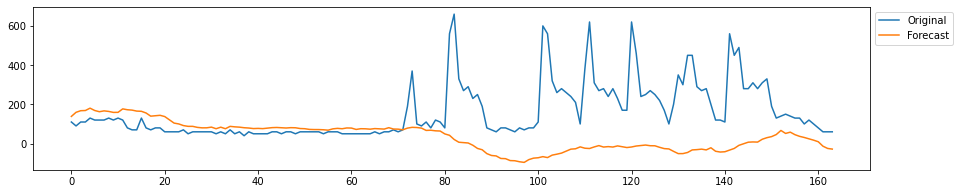

--------------------
training window 17739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:25] getting statistics


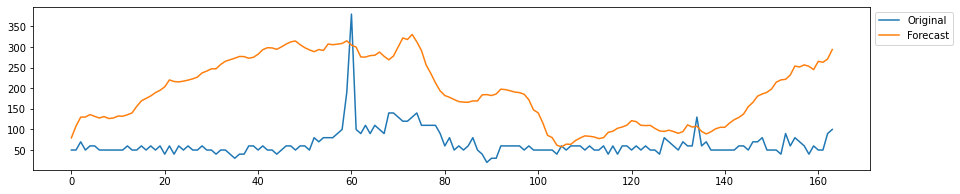

--------------------
training window 18396


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:32] getting statistics


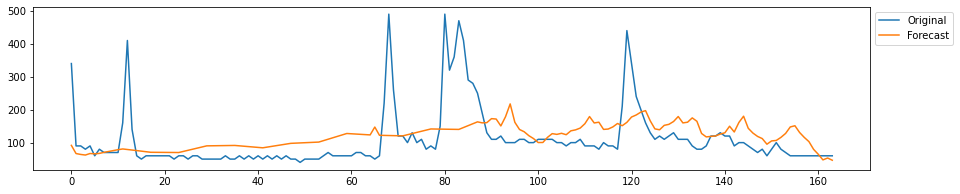

--------------------
training window 19053


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 12:27:39] getting statistics


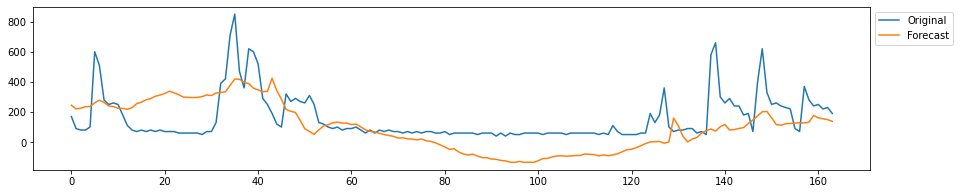

In [36]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        data_train = ttrain.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
        data_test = ttest.loc[:,'lights(t-1)':'Appliances(t)']
        
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'Appliances(t)': 'Appliances(t-1)'}, inplace = True)
        
        start = len(data_train)
        end = len(data_train)+ len(data_test) -1
        #appliance = ttest['Appliances_t+1'].reset_index()
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, sarimax, pca_reduced_train = pca_sarimax.run_train_model(data_train)
        forecast, pca_reduced_test = pca_sarimax.run_test_model(data_test,sarimax,start,end)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(pca_reduced_test['Appliances(t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['Appliances(t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['Appliances(t-1)'],forecast)
        
#         forecast = pd.DataFrame(forecast)
#         forecast.fillna(forecast.mean(),inplace=True)
#         forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Appliances(t-1)'], forecast)
    
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Appliances(t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        
        result["rmse"].append(rmse)
        result["mae"].append(mae)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
measures = pd.DataFrame(result)

In [37]:
measures

,window,rmse,mae,mape,smape
0,0,340.726848,309.658523,538.152782,61.719855
1,657,122.034193,84.165728,94.247342,45.193693
2,1314,350.015969,246.597489,230.165974,62.312799
3,1971,110.120622,83.564336,196.639945,51.899721
4,2628,167.364433,145.118275,208.608254,46.192960
5,3285,127.332749,107.189156,200.906609,43.340442
6,3942,146.074106,110.865723,115.497148,63.005077
7,4599,106.281325,70.325093,102.547771,38.341508
8,5256,208.852222,174.671139,258.781577,51.314383
9,5913,116.293121,70.323523,74.343001,40.564252


In [38]:
### Mean Statistics PCA-SARIMAX

In [40]:
final_result = {
     "rmse": [],
     "mae":[],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-SARIMAX (test): ")
final_measures_pca

Mean Statistics PCA-SARIMAX (test): 


,rmse,mae,mape,smape
0,158.768037,124.465851,170.801876,51.938651
